In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
# load json and create model
json_file = open('color_ARCNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("color_ARCNN_weights_best.h5")
print("Loaded model from disk")

Loaded model from disk


3969

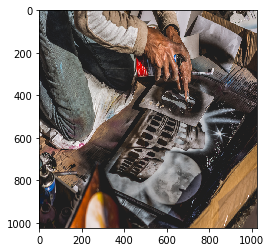

In [49]:
filenames = sorted(os.listdir('DIV2K_train_HR'))

block_size = 32
stride = 16
row_num = (1024 - block_size) // stride + 1
col_num = (1024 - block_size) // stride + 1


img = cv2.resize(cv2.imread('DIV2K_train_HR/'+filenames[440]),(1024,1024))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
test_data = []
for y in range(row_num):
    for x in range(col_num):
        x_start = x*stride
        x_end = x_start+block_size
        y_start = y*stride
        y_end = y_start+block_size
        block = img[y_start:y_end, x_start:x_end, :]
        pred_block = loaded_model.predict(block.reshape(1,32,32,3))
        test_data.append(pred_block.astype('uint8'))

len(test_data)

In [51]:
test_data = np.reshape(test_data,(row_num, col_num, 32,32,3))
print(test_data.shape)

(63, 63, 32, 32, 3)


(1024, 1024, 3)


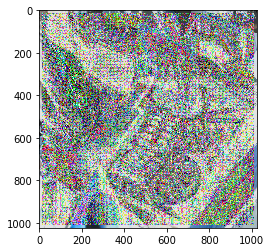

In [55]:
recon = np.ones((img.shape[0],img.shape[1],3))
print(recon.shape)


for i in range(0,row_num):
    for j in range(0,col_num):
        if i%2 == 0 and j%2 == 0:
            recon[i*16:i*16+32,j*16:j*16+32, :] = test_data[i][j]
            
for i in range(0,row_num):
    for j in range(0,col_num):
        if i%2 != 0 and j%2 != 0:
            recon[i*16:i*16+32,j*16:j*16+32] = (recon[i*16:i*16+32,j*16:j*16+32] + test_data[i][j])/2

plt.imshow(recon) 